# **Research Example - DeepBind (2015)**

## **1. Preprocess**
### 1.1. Load the raw data of ***ALX homeobox protein 1*** (SELEX sequencing data) 
- reference - http://tools.genes.toronto.edu/deepbind/D00289.002/index.html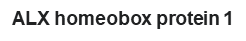
- download 
    - [Training raw dataset](https://1drv.ms/u/s!AljTCh5CK9KvgYltlkAVHPv7kbdytg?e=qBtIgu) 
    - [Testing raw dataset](https://1drv.ms/u/s!AljTCh5CK9KvgYlsgGwcmTp5L-35iQ?e=k8eUxH) 

In [1]:
from collections import defaultdict
import numpy as np

def raw_seq_parser(path):
    f = open(path, "r")
    seqs = []
    seq_lens = []
    labels = []
    flines = f.readlines()
    cols = None
    for i, line in enumerate(flines):
        if not i :
            cols = line.replace("\n","").split("\t")
        else:
            fold_id, event_id, seq, bound = line.replace("\n","").split("\t")
            seqs.append(seq)
            labels.append(int(bound))
            seq_lens.append(len(seq))
            
    num_pos = sum(labels)
    num_neg = len(labels) - num_pos
    print("Load {} finish ({} lines, #positive: {}, #negative: {})".format(path, len(labels), num_pos, num_neg))
    print("- sequence sizes : {}".format(set(seq_lens)))
    
    return seqs, labels


# path of raw data
TRAIN_RAW = "Alx1_DBD_TAAAGC20NCG_3_Z_B.seq"
TEST_RAW  = "Alx1_DBD_TAAAGC20NCG_3_Z_A.seq"
    
train_seqs, y = raw_seq_parser(TRAIN_RAW)
test_seqs, test_y = raw_seq_parser(TEST_RAW)

Load Alx1_DBD_TAAAGC20NCG_3_Z_B.seq finish (255508 lines, #positive: 127754, #negative: 127754)
- sequence sizes : {20}
Load Alx1_DBD_TAAAGC20NCG_3_Z_A.seq finish (128012 lines, #positive: 128012, #negative: 0)
- sequence sizes : {20}


### 1.2. DNA sequence encoding
- Baseline: one-hot encoding
- Due to the length of all sequences in the dataset is same (20bp), we don't need the encoding methods for variable length data

In [2]:
def onehot_encoder(seqs, letters="ACGT"):
    enc = defaultdict(lambda: np.array([1/len(letters)]*len(letters))) # default. [0.25,0.25,0.25,0.25]
    for i,l in enumerate(letters):
        f      = np.zeros(len(letters))
        f[i]   = 1
        enc[l] = f
        
    onehot_features = []
    for seq in seqs:
        feature = []
        for c in seq.upper():
            feature.append(enc[c])
        onehot_features.append(feature)
    onehot_features = np.array(onehot_features)
    print("One-hot encoding finished, with feature shape {}".format(onehot_features.shape))
    return onehot_features

X = onehot_encoder(train_seqs)
test_x = onehot_encoder(test_seqs)

One-hot encoding finished, with feature shape (255508, 20, 4)
One-hot encoding finished, with feature shape (128012, 20, 4)


### 1.3. Split Train & Valid dataset 
- The testset has only positive class
- Most evaluation metrices of binary classification problem need negative class
- We split the training set to train and valid datasets
- The testset only used when the model training is finished

In [3]:
from sklearn.model_selection import train_test_split

X, y = np.array(X), np.array(y) # convert python-list to numpy-array

train_x, valid_x, train_y, valid_y = train_test_split(X, y, 
                                                      test_size=0.33, # ratio of size of train-test set splitting
                                                      random_state=42) # random-seed

print("Train set | x: {}, y: {} \nValid set | x: {}, y: {}".format(train_x.shape,
                                                                   train_y.shape,
                                                                   valid_x.shape,
                                                                   valid_y.shape))

Train set | x: (171190, 20, 4), y: (171190,) 
Valid set | x: (84318, 20, 4), y: (84318,)


In [4]:
train_x = train_x.reshape(-1, 80)[:5000]
valid_x = valid_x.reshape(-1, 80)[:5000]
test_x  = test_x.reshape(-1, 80)[:1000]

train_y = np.array(train_y[:5000])
valid_y = np.array(valid_y[:5000])
test_y  = np.array(test_y[:1000])

print(train_x.shape, valid_x.shape, test_x.shape)
print(train_y.shape, valid_y.shape, test_y.shape)

(5000, 80) (5000, 80) (1000, 80)
(5000,) (5000,) (1000,)


## **2. Binary Classifiers**
### 2.X. Random Forest Classifier

In [5]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight = "balanced", # just for class imbalance
                               n_estimators = 200, # number of decision trees (hyper-param)
                               max_depth    = 10)  # maximum tree depth (hyper-param)

model # print model description

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [6]:
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## **3. Model Evaluations**
### 3.X. Receiver operating characteristic (ROC)

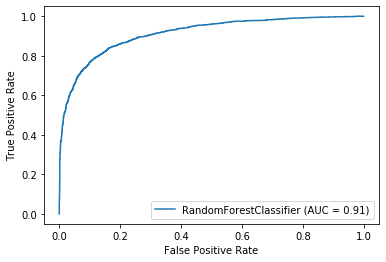

In [7]:
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, model_selection

metrics.plot_roc_curve(model, valid_x, valid_y)
plt.show()

In [8]:
valid_pred_y = model.predict(valid_x)
print(metrics.classification_report(valid_y, valid_pred_y))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      2567
           1       0.85      0.80      0.83      2433

    accuracy                           0.84      5000
   macro avg       0.84      0.84      0.84      5000
weighted avg       0.84      0.84      0.84      5000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:88: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


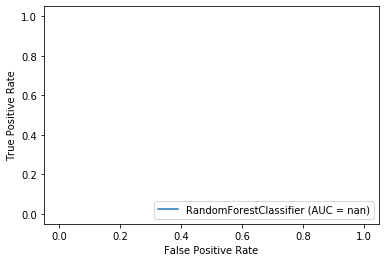

In [9]:
metrics.plot_roc_curve(model, test_x, test_y) # To draw the ROC curve, we need negative samples
plt.show()

In [10]:
test_pred_y = model.predict(test_x)
print(metrics.classification_report(test_y, test_pred_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.81      0.90      1000

    accuracy                           0.81      1000
   macro avg       0.50      0.41      0.45      1000
weighted avg       1.00      0.81      0.90      1000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
